<a href="https://colab.research.google.com/github/akiabe/udemy_PyTorch_DNN/blob/master/pytorch_nonliner_sequence_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

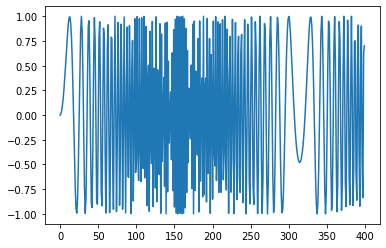

In [13]:
series = np.sin((0.1*np.arange(400))**2)
plt.plot(series)
plt.show()

In [14]:
T = 10
D = 1
X = []
Y = []
for t in range(len(series)-T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print(X.shape)
print(Y.shape)
print(N)

(390, 10, 1)
(390, 1)
390


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [16]:
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True
    )
    self.fc = nn.Linear(self.M, self.K)
  
  def forward (self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    out, _ = self.rnn(X, (h0, c0))
    out = self.fc(out[:,-1,:])
    return out

In [17]:
model = RNN(n_inputs=1, n_hidden=10, n_rnnlayers=1, n_outputs=1)
model.to(device)

RNN(
  (rnn): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [19]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [20]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_losses[it] = loss.item()

    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[it] = test_loss.item()

    if (it+1) % 5 == 0:
      print(f"Epochs {it+1}/{epochs}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f}")

  return train_losses, test_losses

In [21]:
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [22]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epochs 5/200, train loss: 0.5203, test loss: 0.4997
Epochs 10/200, train loss: 0.5074, test loss: 0.5535
Epochs 15/200, train loss: 0.5031, test loss: 0.6193
Epochs 20/200, train loss: 0.4949, test loss: 0.6142
Epochs 25/200, train loss: 0.4753, test loss: 0.6032
Epochs 30/200, train loss: 0.4082, test loss: 0.5564
Epochs 35/200, train loss: 0.3799, test loss: 0.4856
Epochs 40/200, train loss: 0.2760, test loss: 0.3608
Epochs 45/200, train loss: 0.1705, test loss: 0.2291
Epochs 50/200, train loss: 0.1063, test loss: 0.1135
Epochs 55/200, train loss: 0.0772, test loss: 0.0844
Epochs 60/200, train loss: 0.0444, test loss: 0.0836
Epochs 65/200, train loss: 0.0321, test loss: 0.0760
Epochs 70/200, train loss: 0.0242, test loss: 0.0594
Epochs 75/200, train loss: 0.0164, test loss: 0.0493
Epochs 80/200, train loss: 0.0115, test loss: 0.0372
Epochs 85/200, train loss: 0.0097, test loss: 0.0382
Epochs 90/200, train loss: 0.0072, test loss: 0.0398
Epochs 95/200, train loss: 0.0058, test loss: 0

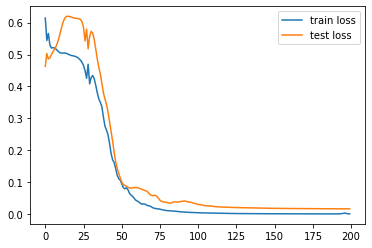

In [23]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [24]:
valid_target = Y[-N//2:]
valid_preds = []
last_x = X_test[0].view(T)
#print(X_test[0])
#print(last_x)

while len(valid_preds) < len(valid_target):
  input_ = last_x.reshape(1, T, 1)
  #print(input_)
  p = model(input_)
  #print(p)
  valid_preds.append(p[0,0].item())
  last_x = torch.cat((last_x[1:], p[0]))

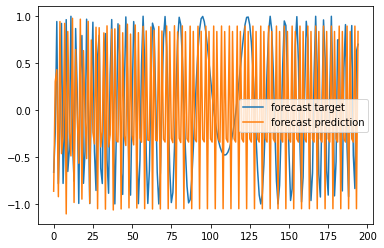

In [25]:
plt.plot(valid_target, label="forecast target")
plt.plot(valid_preds, label="forecast prediction")
plt.legend()
plt.show()